<a href="https://colab.research.google.com/github/infotrix/OCI-ERC-721/blob/main/KN_Disco_Diffusion_v4_1_%5Bw_Video_Inits%2C_Recovery_%26_DDIM_Sharpen%5D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Disco Diffusion v4.1 - Now with Video Inits, Recovery, DDIM Sharpen and improved UI

In case of confusion, Disco is the name of this notebook edit. The diffusion model in use is Katherine Crowson's fine-tuned 512x512 model

For issues, message [@Somnai_dreams](https://twitter.com/Somnai_dreams) or Somnai#6855

Credits & Changelog ⬇️


Original notebook by Katherine Crowson (https://github.com/crowsonkb, https://twitter.com/RiversHaveWings). It uses either OpenAI's 256x256 unconditional ImageNet or Katherine Crowson's fine-tuned 512x512 diffusion model (https://github.com/openai/guided-diffusion), together with CLIP (https://github.com/openai/CLIP) to connect text prompts with images.

Modified by Daniel Russell (https://github.com/russelldc, https://twitter.com/danielrussruss) to include (hopefully) optimal params for quick generations in 15-100 timesteps rather than 1000, as well as more robust augmentations.

Further improvements from Dango233 and nsheppard helped improve the quality of diffusion in general, and especially so for shorter runs like this notebook aims to achieve.

Vark added code to load in multiple Clip models at once, which all prompts are evaluated against, which may greatly improve accuracy.

The latest zoom, pan, rotation, and keyframes features were taken from Chigozie Nri's VQGAN Zoom Notebook (https://github.com/chigozienri, https://twitter.com/chigozienri)

Advanced DangoCutn Cutout method is also from Dango223.

--

I, Somnai (https://twitter.com/Somnai_dreams), have added Diffusion Animation techniques, QoL improvements and various implementations of tech and techniques, mostly listed in the changelog below.

In [ ]:
# @title Licensed under the MIT License

# Copyright (c) 2021 Katherine Crowson 

# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:

# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.

# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
# THE SOFTWARE.

In [ ]:
#@title <- View Changelog

skip_for_run_all = True #@param {type: 'boolean'}

if skip_for_run_all == False:
  print(
      '''
  v1 Update: Oct 29th 2021

      QoL improvements added by Somnai (@somnai_dreams), including user friendly UI, settings+prompt saving and improved google drive folder organization.

  v1.1 Update: Nov 13th 2021

      Now includes sizing options, intermediate saves and fixed image prompts and perlin inits. unexposed batch option since it doesn't work

  v2 Update: Nov 22nd 2021

      Initial addition of Katherine Crowson's Secondary Model Method (https://colab.research.google.com/drive/1mpkrhOjoyzPeSWy2r7T8EYRaU7amYOOi#scrollTo=X5gODNAMEUCR)

      Noticed settings were saving with the wrong name so corrected it. Let me know if you preferred the old scheme.

  v3 Update: Dec 24th 2021

      Implemented Dango's advanced cutout method

      Added SLIP models, thanks to NeuralDivergent

      Fixed issue with NaNs resulting in black images, with massive help and testing from @Softology

      Perlin now changes properly within batches (not sure where this perlin_regen code came from originally, but thank you)

  v4 Update: Jan 2021

      Implemented Diffusion Zooming

      Added Chigozie keyframing

      Made a bunch of edits to processes
  
  v4.1 Update: Jan  14th 2021

      Added video input mode

      Added license that somehow went missing

      Added improved prompt keyframing, fixed image_prompts and multiple prompts

      Improved UI

      Significant under the hood cleanup and improvement

      Refined defaults for each mode

      Added latent-diffusion SuperRes for sharpening

      Added resume run mode

      '''
  )

#Tutorial

**Diffusion settings**
---

This section is outdated as of v2

Setting | Description | Default
--- | --- | ---
**Your vision:**
`text_prompts` | A description of what you'd like the machine to generate. Think of it like writing the caption below your image on a website. | N/A
`image_prompts` | Think of these images more as a description of their contents. | N/A
**Image quality:**
`clip_guidance_scale`  | Controls how much the image should look like the prompt. | 1000
`tv_scale` |  Controls the smoothness of the final output. | 150
`range_scale` |  Controls how far out of range RGB values are allowed to be. | 150
`sat_scale` | Controls how much saturation is allowed. From nshepperd's JAX notebook. | 0
`cutn` | Controls how many crops to take from the image. | 16
`cutn_batches` | Accumulate CLIP gradient from multiple batches of cuts  | 2
**Init settings:**
`init_image` |   URL or local path | None
`init_scale` |  This enhances the effect of the init image, a good value is 1000 | 0
`skip_steps Controls the starting point along the diffusion timesteps | 0
`perlin_init` |  Option to start with random perlin noise | False
`perlin_mode` |  ('gray', 'color') | 'mixed'
**Advanced:**
`skip_augs` |Controls whether to skip torchvision augmentations | False
`randomize_class` |Controls whether the imagenet class is randomly changed each iteration | True
`clip_denoised` |Determines whether CLIP discriminates a noisy or denoised image | False
`clamp_grad` |Experimental: Using adaptive clip grad in the cond_fn | True
`seed`  | Choose a random seed and print it at end of run for reproduction | random_seed
`fuzzy_prompt` | Controls whether to add multiple noisy prompts to the prompt losses | False
`rand_mag` |Controls the magnitude of the random noise | 0.1
`eta` | DDIM hyperparameter | 0.5

..

**Model settings**
---

Setting | Description | Default
--- | --- | ---
**Diffusion:**
`timestep_respacing`  | Modify this value to decrease the number of timesteps. | ddim100
`diffusion_steps` || 1000
**Diffusion:**
`clip_models`  | Models of CLIP to load. Typically the more, the better but they all come at a hefty VRAM cost. | ViT-B/32, ViT-B/16, RN50x4

# 1. Set Up

In [ ]:
#@title 1.1 Check GPU Status
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7b4f26db-4db0-8e6c-cfdc-1ebf7ce75f37)


In [ ]:
from google.colab import drive
#@title 1.2 Prepare Folders
#@markdown If you connect your Google Drive, you can save the final image of each run on your drive.

google_drive = True #@param {type:"boolean"}

#@markdown Click here if you'd like to save the diffusion model checkpoint file to (and/or load from) your Google Drive:
yes_please = True #@param {type:"boolean"}

if google_drive is True:
  drive.mount('/content/drive')
  root_path = '/content/drive/MyDrive/AI/Disco_Diffusion'
else:
  root_path = '/content'

import os
from os import path
#Simple create paths taken with modifications from Datamosh's Batch VQGAN+CLIP notebook
def createPath(filepath):
    if path.exists(filepath) == False:
      os.makedirs(filepath)
      print(f'Made {filepath}')
    else:
      print(f'filepath {filepath} exists.')

initDirPath = f'{root_path}/init_images'
createPath(initDirPath)
outDirPath = f'{root_path}/images_out'
createPath(outDirPath)

if google_drive and not yes_please or not google_drive:
    model_path = '/content/models'
    createPath(model_path)
if google_drive and yes_please:
    model_path = f'{root_path}/models'
    createPath(model_path)
# libraries = f'{root_path}/libraries'
# createPath(libraries)



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
filepath /content/drive/MyDrive/AI/Disco_Diffusion/init_images exists.
filepath /content/drive/MyDrive/AI/Disco_Diffusion/images_out exists.
filepath /content/drive/MyDrive/AI/Disco_Diffusion/models exists.


In [ ]:
#@title ### 1.3 Install and import dependencies

if google_drive is not True:
  root_path = f'/content'
  model_path = '/content/models' 

model_256_downloaded = False
model_512_downloaded = False
model_secondary_downloaded = False

!git clone https://github.com/openai/CLIP
# !git clone https://github.com/facebookresearch/SLIP.git
!git clone https://github.com/crowsonkb/guided-diffusion
!git clone https://github.com/assafshocher/ResizeRight.git
!pip install -e ./CLIP
!pip install -e ./guided-diffusion
!pip install lpips datetime timm
!apt install imagemagick


import sys
# sys.path.append('./SLIP')
sys.path.append('./ResizeRight')
from dataclasses import dataclass
from functools import partial
import cv2
import pandas as pd
import gc
import io
import math
import timm
from IPython import display
import lpips
from PIL import Image, ImageOps
import requests
from glob import glob
import json
from types import SimpleNamespace
import torch
from torch import nn
from torch.nn import functional as F
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from tqdm.notebook import tqdm
sys.path.append('./CLIP')
sys.path.append('./guided-diffusion')
import clip
from resize_right import resize
# from models import SLIP_VITB16, SLIP, SLIP_VITL16
from guided_diffusion.script_util import create_model_and_diffusion, model_and_diffusion_defaults
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import random
from ipywidgets import Output
import hashlib

#SuperRes
!git clone https://github.com/CompVis/latent-diffusion.git
!git clone https://github.com/CompVis/taming-transformers
!pip install -e ./taming-transformers
!pip install ipywidgets omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops wandb

#SuperRes
import ipywidgets as widgets
import os
sys.path.append(".")
sys.path.append('./taming-transformers')
from taming.models import vqgan # checking correct import from taming
from torchvision.datasets.utils import download_url
%cd '/content/latent-diffusion'
from functools import partial
from ldm.util import instantiate_from_config
from ldm.modules.diffusionmodules.util import make_ddim_sampling_parameters, make_ddim_timesteps, noise_like
# from ldm.models.diffusion.ddim import DDIMSampler
from ldm.util import ismap
%cd '/content'
from google.colab import files
from IPython.display import Image as ipyimg
from numpy import asarray
from einops import rearrange, repeat
import torch, torchvision
import time
from omegaconf import OmegaConf
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


import torch
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

if torch.cuda.get_device_capability(device) == (8,0): ## A100 fix thanks to Emad
  print('Disabling CUDNN for A100 gpu', file=sys.stderr)
  torch.backends.cudnn.enabled = False

fatal: destination path 'CLIP' already exists and is not an empty directory.
fatal: destination path 'guided-diffusion' already exists and is not an empty directory.
fatal: destination path 'ResizeRight' already exists and is not an empty directory.
Obtaining file:///content/CLIP
  Attempting uninstall: clip
    Found existing installation: clip 1.0
    Can't uninstall 'clip'. No files were found to uninstall.
  Running setup.py develop for clip
Obtaining file:///content/guided-diffusion
  Attempting uninstall: guided-diffusion
    Found existing installation: guided-diffusion 0.0.0
    Can't uninstall 'guided-diffusion'. No files were found to uninstall.
  Running setup.py develop for guided-diffusion
Reading package lists... Done
Building dependency tree       
Reading state information... Done
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.12).
The following package was automatically installed and is no longer required:
  libnvidia-common-470
Use 'apt autoremove

In [ ]:
#@title 1.4 Define necessary functions

# https://gist.github.com/adefossez/0646dbe9ed4005480a2407c62aac8869

def interp(t):
    return 3 * t**2 - 2 * t ** 3

def perlin(width, height, scale=10, device=None):
    gx, gy = torch.randn(2, width + 1, height + 1, 1, 1, device=device)
    xs = torch.linspace(0, 1, scale + 1)[:-1, None].to(device)
    ys = torch.linspace(0, 1, scale + 1)[None, :-1].to(device)
    wx = 1 - interp(xs)
    wy = 1 - interp(ys)
    dots = 0
    dots += wx * wy * (gx[:-1, :-1] * xs + gy[:-1, :-1] * ys)
    dots += (1 - wx) * wy * (-gx[1:, :-1] * (1 - xs) + gy[1:, :-1] * ys)
    dots += wx * (1 - wy) * (gx[:-1, 1:] * xs - gy[:-1, 1:] * (1 - ys))
    dots += (1 - wx) * (1 - wy) * (-gx[1:, 1:] * (1 - xs) - gy[1:, 1:] * (1 - ys))
    return dots.permute(0, 2, 1, 3).contiguous().view(width * scale, height * scale)

def perlin_ms(octaves, width, height, grayscale, device=device):
    out_array = [0.5] if grayscale else [0.5, 0.5, 0.5]
    # out_array = [0.0] if grayscale else [0.0, 0.0, 0.0]
    for i in range(1 if grayscale else 3):
        scale = 2 ** len(octaves)
        oct_width = width
        oct_height = height
        for oct in octaves:
            p = perlin(oct_width, oct_height, scale, device)
            out_array[i] += p * oct
            scale //= 2
            oct_width *= 2
            oct_height *= 2
    return torch.cat(out_array)

def create_perlin_noise(octaves=[1, 1, 1, 1], width=2, height=2, grayscale=True):
    out = perlin_ms(octaves, width, height, grayscale)
    if grayscale:
        out = TF.resize(size=(side_y, side_x), img=out.unsqueeze(0))
        out = TF.to_pil_image(out.clamp(0, 1)).convert('RGB')
    else:
        out = out.reshape(-1, 3, out.shape[0]//3, out.shape[1])
        out = TF.resize(size=(side_y, side_x), img=out)
        out = TF.to_pil_image(out.clamp(0, 1).squeeze())

    out = ImageOps.autocontrast(out)
    return out

def regen_perlin():
    if perlin_mode == 'color':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
    elif perlin_mode == 'gray':
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
    else:
        init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
        init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)

    init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
    del init2
    return init.expand(batch_size, -1, -1, -1)

def fetch(url_or_path):
    if str(url_or_path).startswith('http://') or str(url_or_path).startswith('https://'):
        r = requests.get(url_or_path)
        r.raise_for_status()
        fd = io.BytesIO()
        fd.write(r.content)
        fd.seek(0)
        return fd
    return open(url_or_path, 'rb')

def read_image_workaround(path):
    """OpenCV reads images as BGR, Pillow saves them as RGB. Work around
    this incompatibility to avoid colour inversions."""
    im_tmp = cv2.imread(path)
    return cv2.cvtColor(im_tmp, cv2.COLOR_BGR2RGB)

def parse_prompt(prompt):
    if prompt.startswith('http://') or prompt.startswith('https://'):
        vals = prompt.rsplit(':', 2)
        vals = [vals[0] + ':' + vals[1], *vals[2:]]
    else:
        vals = prompt.rsplit(':', 1)
    vals = vals + ['', '1'][len(vals):]
    return vals[0], float(vals[1])

def sinc(x):
    return torch.where(x != 0, torch.sin(math.pi * x) / (math.pi * x), x.new_ones([]))

def lanczos(x, a):
    cond = torch.logical_and(-a < x, x < a)
    out = torch.where(cond, sinc(x) * sinc(x/a), x.new_zeros([]))
    return out / out.sum()

def ramp(ratio, width):
    n = math.ceil(width / ratio + 1)
    out = torch.empty([n])
    cur = 0
    for i in range(out.shape[0]):
        out[i] = cur
        cur += ratio
    return torch.cat([-out[1:].flip([0]), out])[1:-1]

def resample(input, size, align_corners=True):
    n, c, h, w = input.shape
    dh, dw = size

    input = input.reshape([n * c, 1, h, w])

    if dh < h:
        kernel_h = lanczos(ramp(dh / h, 2), 2).to(input.device, input.dtype)
        pad_h = (kernel_h.shape[0] - 1) // 2
        input = F.pad(input, (0, 0, pad_h, pad_h), 'reflect')
        input = F.conv2d(input, kernel_h[None, None, :, None])

    if dw < w:
        kernel_w = lanczos(ramp(dw / w, 2), 2).to(input.device, input.dtype)
        pad_w = (kernel_w.shape[0] - 1) // 2
        input = F.pad(input, (pad_w, pad_w, 0, 0), 'reflect')
        input = F.conv2d(input, kernel_w[None, None, None, :])

    input = input.reshape([n, c, h, w])
    return F.interpolate(input, size, mode='bicubic', align_corners=align_corners)

class MakeCutouts(nn.Module):
    def __init__(self, cut_size, cutn, skip_augs=False):
        super().__init__()
        self.cut_size = cut_size
        self.cutn = cutn
        self.skip_augs = skip_augs
        self.augs = T.Compose([
            T.RandomHorizontalFlip(p=0.5),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomPerspective(distortion_scale=0.4, p=0.7),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            T.RandomGrayscale(p=0.15),
            T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
            # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
        ])

    def forward(self, input):
        input = T.Pad(input.shape[2]//4, fill=0)(input)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)

        cutouts = []
        for ch in range(self.cutn):
            if ch > self.cutn - self.cutn//4:
                cutout = input.clone()
            else:
                size = int(max_size * torch.zeros(1,).normal_(mean=.8, std=.3).clip(float(self.cut_size/max_size), 1.))
                offsetx = torch.randint(0, abs(sideX - size + 1), ())
                offsety = torch.randint(0, abs(sideY - size + 1), ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]

            if not self.skip_augs:
                cutout = self.augs(cutout)
            cutouts.append(resample(cutout, (self.cut_size, self.cut_size)))
            del cutout

        cutouts = torch.cat(cutouts, dim=0)
        return cutouts

cutout_debug = False
padargs = {}

class MakeCutoutsDango(nn.Module):
    def __init__(self, cut_size,
                 Overview=4, 
                 InnerCrop = 0, IC_Size_Pow=0.5, IC_Grey_P = 0.2
                 ):
        super().__init__()
        self.cut_size = cut_size
        self.Overview = Overview
        self.InnerCrop = InnerCrop
        self.IC_Size_Pow = IC_Size_Pow
        self.IC_Grey_P = IC_Grey_P
        if args.animation_mode == 'None':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif args.animation_mode == 'Video Input':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.5),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=15, translate=(0.1, 0.1)),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomPerspective(distortion_scale=0.4, p=0.7),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.15),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              # T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
          ])
        elif  args.animation_mode == '2D':
          self.augs = T.Compose([
              T.RandomHorizontalFlip(p=0.4),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomAffine(degrees=10, translate=(0.05, 0.05),  interpolation = T.InterpolationMode.BILINEAR),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.RandomGrayscale(p=0.1),
              T.Lambda(lambda x: x + torch.randn_like(x) * 0.01),
              T.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.3),
          ])
          

    def forward(self, input):
        cutouts = []
        gray = T.Grayscale(3)
        sideY, sideX = input.shape[2:4]
        max_size = min(sideX, sideY)
        min_size = min(sideX, sideY, self.cut_size)
        l_size = max(sideX, sideY)
        output_shape = [1,3,self.cut_size,self.cut_size] 
        output_shape_2 = [1,3,self.cut_size+2,self.cut_size+2]
        pad_input = F.pad(input,((sideY-max_size)//2,(sideY-max_size)//2,(sideX-max_size)//2,(sideX-max_size)//2), **padargs)
        cutout = resize(pad_input, out_shape=output_shape)

        if self.Overview>0:
            if self.Overview<=4:
                if self.Overview>=1:
                    cutouts.append(cutout)
                if self.Overview>=2:
                    cutouts.append(gray(cutout))
                if self.Overview>=3:
                    cutouts.append(TF.hflip(cutout))
                if self.Overview==4:
                    cutouts.append(gray(TF.hflip(cutout)))
            else:
                cutout = resize(pad_input, out_shape=output_shape)
                for _ in range(self.Overview):
                    cutouts.append(cutout)

            if cutout_debug:
                TF.to_pil_image(cutouts[0].clamp(0, 1).squeeze(0)).save("/content/cutout_overview0.jpg",quality=99)
                              
        if self.InnerCrop >0:
            for i in range(self.InnerCrop):
                size = int(torch.rand([])**self.IC_Size_Pow * (max_size - min_size) + min_size)
                offsetx = torch.randint(0, sideX - size + 1, ())
                offsety = torch.randint(0, sideY - size + 1, ())
                cutout = input[:, :, offsety:offsety + size, offsetx:offsetx + size]
                if i <= int(self.IC_Grey_P * self.InnerCrop):
                    cutout = gray(cutout)
                cutout = resize(cutout, out_shape=output_shape)
                cutouts.append(cutout)
            if cutout_debug:
                TF.to_pil_image(cutouts[-1].clamp(0, 1).squeeze(0)).save("/content/cutout_InnerCrop.jpg",quality=99)
        cutouts = torch.cat(cutouts)
        if skip_augs is not True: cutouts=self.augs(cutouts)
        return cutouts

def spherical_dist_loss(x, y):
    x = F.normalize(x, dim=-1)
    y = F.normalize(y, dim=-1)
    return (x - y).norm(dim=-1).div(2).arcsin().pow(2).mul(2)     

def tv_loss(input):
    """L2 total variation loss, as in Mahendran et al."""
    input = F.pad(input, (0, 1, 0, 1), 'replicate')
    x_diff = input[..., :-1, 1:] - input[..., :-1, :-1]
    y_diff = input[..., 1:, :-1] - input[..., :-1, :-1]
    return (x_diff**2 + y_diff**2).mean([1, 2, 3])


def range_loss(input):
    return (input - input.clamp(-1, 1)).pow(2).mean([1, 2, 3])

stop_on_next_loop = False  # Make sure GPU memory doesn't get corrupted from cancelling the run mid-way through, allow a full frame to complete

def do_run():
  seed = args.seed
  print(range(args.start_frame, args.max_frames))
  for frame_num in range(args.start_frame, args.max_frames):
      if stop_on_next_loop:
        break
      
      display.clear_output(wait=True)

      # Print Frame progress if animation mode is on
      if args.animation_mode != "None":
        batchBar = tqdm(range(args.max_frames), desc ="Frames")
        batchBar.n = frame_num
        batchBar.refresh()

      
      # Inits if not video frames
      if args.animation_mode != "Video Input":
        if args.init_image == '':
          init_image = None
        else:
          init_image = args.init_image
        init_scale = args.init_scale
        skip_steps = args.skip_steps

      if args.animation_mode == "2D":
        if args.key_frames:
          angle = args.angle_series[frame_num]
          zoom = args.zoom_series[frame_num]
          translation_x = args.translation_x_series[frame_num]
          translation_y = args.translation_y_series[frame_num]
          print(
              f'angle: {angle}',
              f'zoom: {zoom}',
              f'translation_x: {translation_x}',
              f'translation_y: {translation_y}',
          )
        
        if frame_num > 0:
          seed = seed + 1          
          if resume_run and frame_num == start_frame:
            img_0 = cv2.imread(batchFolder+f"/{batch_name}({batchNum})_{start_frame-1:04}.png")
          else:
            img_0 = cv2.imread('prevFrame.png')
          center = (1*img_0.shape[1]//2, 1*img_0.shape[0]//2)
          trans_mat = np.float32(
              [[1, 0, translation_x],
              [0, 1, translation_y]]
          )
          rot_mat = cv2.getRotationMatrix2D( center, angle, zoom )
          trans_mat = np.vstack([trans_mat, [0,0,1]])
          rot_mat = np.vstack([rot_mat, [0,0,1]])
          transformation_matrix = np.matmul(rot_mat, trans_mat)
          img_0 = cv2.warpPerspective(
              img_0,
              transformation_matrix,
              (img_0.shape[1], img_0.shape[0]),
              borderMode=cv2.BORDER_WRAP
          )
          cv2.imwrite('prevFrameScaled.png', img_0)
          init_image = 'prevFrameScaled.png'
          init_scale = args.frames_scale
          skip_steps = args.calc_frames_skip_steps

      if  args.animation_mode == "Video Input":
        seed = seed + 1  
        init_image = f'{videoFramesFolder}/{frame_num+1:04}.jpg'
        init_scale = args.frames_scale
        skip_steps = args.calc_frames_skip_steps

      loss_values = []
  
      if seed is not None:
          np.random.seed(seed)
          random.seed(seed)
          torch.manual_seed(seed)
          torch.cuda.manual_seed_all(seed)
          torch.backends.cudnn.deterministic = True
  
      target_embeds, weights = [], []
      
      if args.prompts_series is not None and frame_num >= len(args.prompts_series):
        frame_prompt = args.prompts_series[-1]
      elif args.prompts_series is not None:
        frame_prompt = args.prompts_series[frame_num]
      else:
        frame_prompt = []
      
      print(args.image_prompts_series)
      if args.image_prompts_series is not None and frame_num >= len(args.image_prompts_series):
        image_prompt = args.image_prompts_series[-1]
      elif args.image_prompts_series is not None:
        image_prompt = args.image_prompts_series[frame_num]
      else:
        image_prompt = []

      print(f'Frame Prompt: {frame_prompt}')

      model_stats = []
      for clip_model in clip_models:
            cutn = 16
            model_stat = {"clip_model":None,"target_embeds":[],"make_cutouts":None,"weights":[]}
            model_stat["clip_model"] = clip_model
            
            
            for prompt in frame_prompt:
                txt, weight = parse_prompt(prompt)
                txt = clip_model.encode_text(clip.tokenize(prompt).to(device)).float()
                
                if args.fuzzy_prompt:
                    for i in range(25):
                        model_stat["target_embeds"].append((txt + torch.randn(txt.shape).cuda() * args.rand_mag).clamp(0,1))
                        model_stat["weights"].append(weight)
                else:
                    model_stat["target_embeds"].append(txt)
                    model_stat["weights"].append(weight)
        
            if image_prompt:
              model_stat["make_cutouts"] = MakeCutouts(clip_model.visual.input_resolution, cutn, skip_augs=skip_augs) 
              for prompt in image_prompt:
                  path, weight = parse_prompt(prompt)
                  img = Image.open(fetch(path)).convert('RGB')
                  img = TF.resize(img, min(side_x, side_y, *img.size), T.InterpolationMode.LANCZOS)
                  batch = model_stat["make_cutouts"](TF.to_tensor(img).to(device).unsqueeze(0).mul(2).sub(1))
                  embed = clip_model.encode_image(normalize(batch)).float()
                  if fuzzy_prompt:
                      for i in range(25):
                          model_stat["target_embeds"].append((embed + torch.randn(embed.shape).cuda() * rand_mag).clamp(0,1))
                          weights.extend([weight / cutn] * cutn)
                  else:
                      model_stat["target_embeds"].append(embed)
                      model_stat["weights"].extend([weight / cutn] * cutn)
        
            model_stat["target_embeds"] = torch.cat(model_stat["target_embeds"])
            model_stat["weights"] = torch.tensor(model_stat["weights"], device=device)
            if model_stat["weights"].sum().abs() < 1e-3:
                raise RuntimeError('The weights must not sum to 0.')
            model_stat["weights"] /= model_stat["weights"].sum().abs()
            model_stats.append(model_stat)
  
      init = None
      if init_image is not None:
          init = Image.open(fetch(init_image)).convert('RGB')
          init = init.resize((args.side_x, args.side_y), Image.LANCZOS)
          init = TF.to_tensor(init).to(device).unsqueeze(0).mul(2).sub(1)
      
      if args.perlin_init:
          if args.perlin_mode == 'color':
              init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
              init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, False)
          elif args.perlin_mode == 'gray':
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, True)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          else:
            init = create_perlin_noise([1.5**-i*0.5 for i in range(12)], 1, 1, False)
            init2 = create_perlin_noise([1.5**-i*0.5 for i in range(8)], 4, 4, True)
          # init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device)
          init = TF.to_tensor(init).add(TF.to_tensor(init2)).div(2).to(device).unsqueeze(0).mul(2).sub(1)
          del init2
  
      cur_t = None
  
      def cond_fn(x, t, y=None):
          with torch.enable_grad():
              x_is_NaN = False
              x = x.detach().requires_grad_()
              n = x.shape[0]
              if use_secondary_model is True:
                alpha = torch.tensor(diffusion.sqrt_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                sigma = torch.tensor(diffusion.sqrt_one_minus_alphas_cumprod[cur_t], device=device, dtype=torch.float32)
                cosine_t = alpha_sigma_to_t(alpha, sigma)
                out = secondary_model(x, cosine_t[None].repeat([n])).pred
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              else:
                my_t = torch.ones([n], device=device, dtype=torch.long) * cur_t
                out = diffusion.p_mean_variance(model, x, my_t, clip_denoised=False, model_kwargs={'y': y})
                fac = diffusion.sqrt_one_minus_alphas_cumprod[cur_t]
                x_in = out['pred_xstart'] * fac + x * (1 - fac)
                x_in_grad = torch.zeros_like(x_in)
              for model_stat in model_stats:
                for i in range(args.cutn_batches):
                    t_int = int(t.item())+1 #errors on last step without +1, need to find source
                    #when using SLIP Base model the dimensions need to be hard coded to avoid AttributeError: 'VisionTransformer' object has no attribute 'input_resolution'
                    try:
                        input_resolution=model_stat["clip_model"].visual.input_resolution
                    except:
                        input_resolution=224

                    cuts = MakeCutoutsDango(input_resolution,
                            Overview= args.cut_overview[1000-t_int], 
                            InnerCrop = args.cut_innercut[1000-t_int], IC_Size_Pow=args.cut_ic_pow, IC_Grey_P = args.cut_icgray_p[1000-t_int]
                            )
                    clip_in = normalize(cuts(x_in.add(1).div(2)))
                    image_embeds = model_stat["clip_model"].encode_image(clip_in).float()
                    dists = spherical_dist_loss(image_embeds.unsqueeze(1), model_stat["target_embeds"].unsqueeze(0))
                    dists = dists.view([args.cut_overview[1000-t_int]+args.cut_innercut[1000-t_int], n, -1])
                    losses = dists.mul(model_stat["weights"]).sum(2).mean(0)
                    loss_values.append(losses.sum().item()) # log loss, probably shouldn't do per cutn_batch
                    x_in_grad += torch.autograd.grad(losses.sum() * clip_guidance_scale, x_in)[0] / cutn_batches
              tv_losses = tv_loss(x_in)
              if use_secondary_model is True:
                range_losses = range_loss(out)
              else:
                range_losses = range_loss(out['pred_xstart'])
              sat_losses = torch.abs(x_in - x_in.clamp(min=-1,max=1)).mean()
              loss = tv_losses.sum() * tv_scale + range_losses.sum() * range_scale + sat_losses.sum() * sat_scale
              if init is not None and args.init_scale:
                  init_losses = lpips_model(x_in, init)
                  loss = loss + init_losses.sum() * args.init_scale
              x_in_grad += torch.autograd.grad(loss, x_in)[0]
              if torch.isnan(x_in_grad).any()==False:
                  grad = -torch.autograd.grad(x_in, x, x_in_grad)[0]
              else:
                # print("NaN'd")
                x_is_NaN = True
                grad = torch.zeros_like(x)
          if args.clamp_grad and x_is_NaN == False:
              magnitude = grad.square().mean().sqrt()
              return grad * magnitude.clamp(max=args.clamp_max) / magnitude  #min=-0.02, min=-clamp_max, 
          return grad
  
      if model_config['timestep_respacing'].startswith('ddim'):
          sample_fn = diffusion.ddim_sample_loop_progressive
      else:
          sample_fn = diffusion.p_sample_loop_progressive
    

      image_display = Output()
      for i in range(args.n_batches):
          if args.animation_mode == 'None':
            display.clear_output(wait=True)
            batchBar = tqdm(range(args.n_batches), desc ="Batches")
            batchBar.n = i
            batchBar.refresh()
          print('')
          display.display(image_display)
          gc.collect()
          torch.cuda.empty_cache()
          cur_t = diffusion.num_timesteps - skip_steps - 1
          total_steps = cur_t

          if perlin_init:
              init = regen_perlin()

          if model_config['timestep_respacing'].startswith('ddim'):
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
                  eta=eta,
              )
          else:
              samples = sample_fn(
                  model,
                  (batch_size, 3, args.side_y, args.side_x),
                  clip_denoised=clip_denoised,
                  model_kwargs={},
                  cond_fn=cond_fn,
                  progress=True,
                  skip_timesteps=skip_steps,
                  init_image=init,
                  randomize_class=randomize_class,
              )
          
          
          # with run_display:
          # display.clear_output(wait=True)
          imgToSharpen = None
          for j, sample in enumerate(samples):    
            cur_t -= 1
            intermediateStep = False
            if args.steps_per_checkpoint is not None:
                if j % steps_per_checkpoint == 0 and j > 0:
                  intermediateStep = True
            elif j in args.intermediate_saves:
              intermediateStep = True
            with image_display:
              if j % args.display_rate == 0 or cur_t == -1 or intermediateStep == True:
                  for k, image in enumerate(sample['pred_xstart']):
                      # tqdm.write(f'Batch {i}, step {j}, output {k}:')
                      current_time = datetime.now().strftime('%y%m%d-%H%M%S_%f')
                      percent = math.ceil(j/total_steps*100)
                      if args.n_batches > 0:
                        #if intermediates are saved to the subfolder, don't append a step or percentage to the name
                        if cur_t == -1 and args.intermediates_in_subfolder is True:
                          save_num = f'{frame_num:04}' if animation_mode != "None" else i
                          filename = f'{args.batch_name}({args.batchNum})_{save_num}.png'
                        else:
                          #If we're working with percentages, append it
                          if args.steps_per_checkpoint is not None:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{percent:02}%.png'
                          # Or else, iIf we're working with specific steps, append those
                          else:
                            filename = f'{args.batch_name}({args.batchNum})_{i:04}-{j:03}.png'
                      image = TF.to_pil_image(image.add(1).div(2).clamp(0, 1))
                      if j % args.display_rate == 0 or cur_t == -1:
                        image.save('progress.png')
                        display.clear_output(wait=True)
                        display.display(display.Image('progress.png'))
                      if args.steps_per_checkpoint is not None:
                        if j % args.steps_per_checkpoint == 0 and j > 0:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      else:
                        if j in args.intermediate_saves:
                          if args.intermediates_in_subfolder is True:
                            image.save(f'{partialFolder}/{filename}')
                          else:
                            image.save(f'{batchFolder}/{filename}')
                      if cur_t == -1:
                        if frame_num == 0:
                          save_settings()
                        if args.animation_mode != "None":
                          image.save('prevFrame.png')
                        if args.sharpen_preset != "Off" and animation_mode == "None":
                          imgToSharpen = image
                          if args.keep_unsharp is True:
                            image.save(f'{unsharpenFolder}/{filename}')
                        else:
                          image.save(f'{batchFolder}/{filename}')
                        # if frame_num != args.max_frames-1:
                        #   display.clear_output()

          with image_display:   
            if args.sharpen_preset != "Off" and animation_mode == "None":
              print('Starting Diffusion Sharpening...')
              do_superres(imgToSharpen, f'{batchFolder}/{filename}')
              display.clear_output()
          
          plt.plot(np.array(loss_values), 'r')

def save_settings():
  setting_list = {
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    # 'cutn': cutn,
    'cutn_batches': cutn_batches,
    'max_frames': max_frames,
    'interp_spline': interp_spline,
    # 'rotation_per_frame': rotation_per_frame,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    # 'zoom_per_frame': zoom_per_frame,
    'frames_scale': frames_scale,
    'frames_skip_steps': frames_skip_steps,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'seed': seed,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
    'eta': eta,
    'width': width_height[0],
    'height': width_height[1],
    'diffusion_model': diffusion_model,
    'use_secondary_model': use_secondary_model,
    'steps': steps,
    'diffusion_steps': diffusion_steps,
    'ViTB32': ViTB32,
    'ViTB16': ViTB16,
    'ViTL14': ViTL14,
    'RN101': RN101,
    'RN50': RN50,
    'RN50x4': RN50x4,
    'RN50x16': RN50x16,
    'RN50x64': RN50x64,
    'cut_overview': str(cut_overview),
    'cut_innercut': str(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': str(cut_icgray_p),
    'key_frames': key_frames,
    'max_frames': max_frames,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'video_init_path':video_init_path,
    'extract_nth_frame':extract_nth_frame,
  }
  # print('Settings:', setting_list)
  with open(f"{batchFolder}/{batch_name}({batchNum})_settings.txt", "w+") as f:   #save settings
    json.dump(setting_list, f, ensure_ascii=False, indent=4)
  

In [ ]:
#@title 1.5 Define the secondary diffusion model

def append_dims(x, n):
    return x[(Ellipsis, *(None,) * (n - x.ndim))]


def expand_to_planes(x, shape):
    return append_dims(x, len(shape)).repeat([1, 1, *shape[2:]])


def alpha_sigma_to_t(alpha, sigma):
    return torch.atan2(sigma, alpha) * 2 / math.pi


def t_to_alpha_sigma(t):
    return torch.cos(t * math.pi / 2), torch.sin(t * math.pi / 2)


@dataclass
class DiffusionOutput:
    v: torch.Tensor
    pred: torch.Tensor
    eps: torch.Tensor


class ConvBlock(nn.Sequential):
    def __init__(self, c_in, c_out):
        super().__init__(
            nn.Conv2d(c_in, c_out, 3, padding=1),
            nn.ReLU(inplace=True),
        )


class SkipBlock(nn.Module):
    def __init__(self, main, skip=None):
        super().__init__()
        self.main = nn.Sequential(*main)
        self.skip = skip if skip else nn.Identity()

    def forward(self, input):
        return torch.cat([self.main(input), self.skip(input)], dim=1)


class FourierFeatures(nn.Module):
    def __init__(self, in_features, out_features, std=1.):
        super().__init__()
        assert out_features % 2 == 0
        self.weight = nn.Parameter(torch.randn([out_features // 2, in_features]) * std)

    def forward(self, input):
        f = 2 * math.pi * input @ self.weight.T
        return torch.cat([f.cos(), f.sin()], dim=-1)


class SecondaryDiffusionImageNet(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count

        self.timestep_embed = FourierFeatures(1, 16)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, c),
            ConvBlock(c, c),
            SkipBlock([
                nn.AvgPool2d(2),
                ConvBlock(c, c * 2),
                ConvBlock(c * 2, c * 2),
                SkipBlock([
                    nn.AvgPool2d(2),
                    ConvBlock(c * 2, c * 4),
                    ConvBlock(c * 4, c * 4),
                    SkipBlock([
                        nn.AvgPool2d(2),
                        ConvBlock(c * 4, c * 8),
                        ConvBlock(c * 8, c * 4),
                        nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                    ]),
                    ConvBlock(c * 8, c * 4),
                    ConvBlock(c * 4, c * 2),
                    nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
                ]),
                ConvBlock(c * 4, c * 2),
                ConvBlock(c * 2, c),
                nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
            ]),
            ConvBlock(c * 2, c),
            nn.Conv2d(c, 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


class SecondaryDiffusionImageNet2(nn.Module):
    def __init__(self):
        super().__init__()
        c = 64  # The base channel count
        cs = [c, c * 2, c * 2, c * 4, c * 4, c * 8]

        self.timestep_embed = FourierFeatures(1, 16)
        self.down = nn.AvgPool2d(2)
        self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False)

        self.net = nn.Sequential(
            ConvBlock(3 + 16, cs[0]),
            ConvBlock(cs[0], cs[0]),
            SkipBlock([
                self.down,
                ConvBlock(cs[0], cs[1]),
                ConvBlock(cs[1], cs[1]),
                SkipBlock([
                    self.down,
                    ConvBlock(cs[1], cs[2]),
                    ConvBlock(cs[2], cs[2]),
                    SkipBlock([
                        self.down,
                        ConvBlock(cs[2], cs[3]),
                        ConvBlock(cs[3], cs[3]),
                        SkipBlock([
                            self.down,
                            ConvBlock(cs[3], cs[4]),
                            ConvBlock(cs[4], cs[4]),
                            SkipBlock([
                                self.down,
                                ConvBlock(cs[4], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[5]),
                                ConvBlock(cs[5], cs[4]),
                                self.up,
                            ]),
                            ConvBlock(cs[4] * 2, cs[4]),
                            ConvBlock(cs[4], cs[3]),
                            self.up,
                        ]),
                        ConvBlock(cs[3] * 2, cs[3]),
                        ConvBlock(cs[3], cs[2]),
                        self.up,
                    ]),
                    ConvBlock(cs[2] * 2, cs[2]),
                    ConvBlock(cs[2], cs[1]),
                    self.up,
                ]),
                ConvBlock(cs[1] * 2, cs[1]),
                ConvBlock(cs[1], cs[0]),
                self.up,
            ]),
            ConvBlock(cs[0] * 2, cs[0]),
            nn.Conv2d(cs[0], 3, 3, padding=1),
        )

    def forward(self, input, t):
        timestep_embed = expand_to_planes(self.timestep_embed(t[:, None]), input.shape)
        v = self.net(torch.cat([input, timestep_embed], dim=1))
        alphas, sigmas = map(partial(append_dims, n=v.ndim), t_to_alpha_sigma(t))
        pred = input * alphas - v * sigmas
        eps = input * sigmas + v * alphas
        return DiffusionOutput(v, pred, eps)


In [ ]:
#@title 1.6 SuperRes Define
class DDIMSampler(object):
    def __init__(self, model, schedule="linear", **kwargs):
        super().__init__()
        self.model = model
        self.ddpm_num_timesteps = model.num_timesteps
        self.schedule = schedule

    def register_buffer(self, name, attr):
        if type(attr) == torch.Tensor:
            if attr.device != torch.device("cuda"):
                attr = attr.to(torch.device("cuda"))
        setattr(self, name, attr)

    def make_schedule(self, ddim_num_steps, ddim_discretize="uniform", ddim_eta=0., verbose=True):
        self.ddim_timesteps = make_ddim_timesteps(ddim_discr_method=ddim_discretize, num_ddim_timesteps=ddim_num_steps,
                                                  num_ddpm_timesteps=self.ddpm_num_timesteps,verbose=verbose)
        alphas_cumprod = self.model.alphas_cumprod
        assert alphas_cumprod.shape[0] == self.ddpm_num_timesteps, 'alphas have to be defined for each timestep'
        to_torch = lambda x: x.clone().detach().to(torch.float32).to(self.model.device)

        self.register_buffer('betas', to_torch(self.model.betas))
        self.register_buffer('alphas_cumprod', to_torch(alphas_cumprod))
        self.register_buffer('alphas_cumprod_prev', to_torch(self.model.alphas_cumprod_prev))

        # calculations for diffusion q(x_t | x_{t-1}) and others
        self.register_buffer('sqrt_alphas_cumprod', to_torch(np.sqrt(alphas_cumprod.cpu())))
        self.register_buffer('sqrt_one_minus_alphas_cumprod', to_torch(np.sqrt(1. - alphas_cumprod.cpu())))
        self.register_buffer('log_one_minus_alphas_cumprod', to_torch(np.log(1. - alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recip_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu())))
        self.register_buffer('sqrt_recipm1_alphas_cumprod', to_torch(np.sqrt(1. / alphas_cumprod.cpu() - 1)))

        # ddim sampling parameters
        ddim_sigmas, ddim_alphas, ddim_alphas_prev = make_ddim_sampling_parameters(alphacums=alphas_cumprod.cpu(),
                                                                                   ddim_timesteps=self.ddim_timesteps,
                                                                                   eta=ddim_eta,verbose=verbose)
        self.register_buffer('ddim_sigmas', ddim_sigmas)
        self.register_buffer('ddim_alphas', ddim_alphas)
        self.register_buffer('ddim_alphas_prev', ddim_alphas_prev)
        self.register_buffer('ddim_sqrt_one_minus_alphas', np.sqrt(1. - ddim_alphas))
        sigmas_for_original_sampling_steps = ddim_eta * torch.sqrt(
            (1 - self.alphas_cumprod_prev) / (1 - self.alphas_cumprod) * (
                        1 - self.alphas_cumprod / self.alphas_cumprod_prev))
        self.register_buffer('ddim_sigmas_for_original_num_steps', sigmas_for_original_sampling_steps)

    @torch.no_grad()
    def sample(self,
               S,
               batch_size,
               shape,
               conditioning=None,
               callback=None,
               normals_sequence=None,
               img_callback=None,
               quantize_x0=False,
               eta=0.,
               mask=None,
               x0=None,
               temperature=1.,
               noise_dropout=0.,
               score_corrector=None,
               corrector_kwargs=None,
               verbose=True,
               x_T=None,
               log_every_t=100,
               **kwargs
               ):
        if conditioning is not None:
            if isinstance(conditioning, dict):
                cbs = conditioning[list(conditioning.keys())[0]].shape[0]
                if cbs != batch_size:
                    print(f"Warning: Got {cbs} conditionings but batch-size is {batch_size}")
            else:
                if conditioning.shape[0] != batch_size:
                    print(f"Warning: Got {conditioning.shape[0]} conditionings but batch-size is {batch_size}")

        self.make_schedule(ddim_num_steps=S, ddim_eta=eta, verbose=verbose)
        # sampling
        C, H, W = shape
        size = (batch_size, C, H, W)
        # print(f'Data shape for DDIM sampling is {size}, eta {eta}')

        samples, intermediates = self.ddim_sampling(conditioning, size,
                                                    callback=callback,
                                                    img_callback=img_callback,
                                                    quantize_denoised=quantize_x0,
                                                    mask=mask, x0=x0,
                                                    ddim_use_original_steps=False,
                                                    noise_dropout=noise_dropout,
                                                    temperature=temperature,
                                                    score_corrector=score_corrector,
                                                    corrector_kwargs=corrector_kwargs,
                                                    x_T=x_T,
                                                    log_every_t=log_every_t
                                                    )
        return samples, intermediates

    @torch.no_grad()
    def ddim_sampling(self, cond, shape,
                      x_T=None, ddim_use_original_steps=False,
                      callback=None, timesteps=None, quantize_denoised=False,
                      mask=None, x0=None, img_callback=None, log_every_t=100,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        device = self.model.betas.device
        b = shape[0]
        if x_T is None:
            img = torch.randn(shape, device=device)
        else:
            img = x_T

        if timesteps is None:
            timesteps = self.ddpm_num_timesteps if ddim_use_original_steps else self.ddim_timesteps
        elif timesteps is not None and not ddim_use_original_steps:
            subset_end = int(min(timesteps / self.ddim_timesteps.shape[0], 1) * self.ddim_timesteps.shape[0]) - 1
            timesteps = self.ddim_timesteps[:subset_end]

        intermediates = {'x_inter': [img], 'pred_x0': [img]}
        time_range = reversed(range(0,timesteps)) if ddim_use_original_steps else np.flip(timesteps)
        total_steps = timesteps if ddim_use_original_steps else timesteps.shape[0]
        print(f"Running DDIM Sharpening with {total_steps} timesteps")

        iterator = tqdm(time_range, desc='DDIM Sharpening', total=total_steps)

        for i, step in enumerate(iterator):
            index = total_steps - i - 1
            ts = torch.full((b,), step, device=device, dtype=torch.long)

            if mask is not None:
                assert x0 is not None
                img_orig = self.model.q_sample(x0, ts)  # TODO: deterministic forward pass?
                img = img_orig * mask + (1. - mask) * img

            outs = self.p_sample_ddim(img, cond, ts, index=index, use_original_steps=ddim_use_original_steps,
                                      quantize_denoised=quantize_denoised, temperature=temperature,
                                      noise_dropout=noise_dropout, score_corrector=score_corrector,
                                      corrector_kwargs=corrector_kwargs)
            img, pred_x0 = outs
            if callback: callback(i)
            if img_callback: img_callback(pred_x0, i)

            if index % log_every_t == 0 or index == total_steps - 1:
                intermediates['x_inter'].append(img)
                intermediates['pred_x0'].append(pred_x0)

        return img, intermediates

    @torch.no_grad()
    def p_sample_ddim(self, x, c, t, index, repeat_noise=False, use_original_steps=False, quantize_denoised=False,
                      temperature=1., noise_dropout=0., score_corrector=None, corrector_kwargs=None):
        b, *_, device = *x.shape, x.device
        e_t = self.model.apply_model(x, t, c)
        if score_corrector is not None:
            assert self.model.parameterization == "eps"
            e_t = score_corrector.modify_score(self.model, e_t, x, t, c, **corrector_kwargs)

        alphas = self.model.alphas_cumprod if use_original_steps else self.ddim_alphas
        alphas_prev = self.model.alphas_cumprod_prev if use_original_steps else self.ddim_alphas_prev
        sqrt_one_minus_alphas = self.model.sqrt_one_minus_alphas_cumprod if use_original_steps else self.ddim_sqrt_one_minus_alphas
        sigmas = self.model.ddim_sigmas_for_original_num_steps if use_original_steps else self.ddim_sigmas
        # select parameters corresponding to the currently considered timestep
        a_t = torch.full((b, 1, 1, 1), alphas[index], device=device)
        a_prev = torch.full((b, 1, 1, 1), alphas_prev[index], device=device)
        sigma_t = torch.full((b, 1, 1, 1), sigmas[index], device=device)
        sqrt_one_minus_at = torch.full((b, 1, 1, 1), sqrt_one_minus_alphas[index],device=device)

        # current prediction for x_0
        pred_x0 = (x - sqrt_one_minus_at * e_t) / a_t.sqrt()
        if quantize_denoised:
            pred_x0, _, *_ = self.model.first_stage_model.quantize(pred_x0)
        # direction pointing to x_t
        dir_xt = (1. - a_prev - sigma_t**2).sqrt() * e_t
        noise = sigma_t * noise_like(x.shape, device, repeat_noise) * temperature
        if noise_dropout > 0.:
            noise = torch.nn.functional.dropout(noise, p=noise_dropout)
        x_prev = a_prev.sqrt() * pred_x0 + dir_xt + noise
        return x_prev, pred_x0


def download_models(mode):

    if mode == "superresolution":
        # this is the small bsr light model
        url_conf = 'https://heibox.uni-heidelberg.de/f/31a76b13ea27482981b4/?dl=1'
        url_ckpt = 'https://heibox.uni-heidelberg.de/f/578df07c8fc04ffbadf3/?dl=1'

        path_conf = f'{model_path}/superres/project.yaml'
        path_ckpt = f'{model_path}/superres/last.ckpt'

        download_url(url_conf, path_conf)
        download_url(url_ckpt, path_ckpt)

        path_conf = path_conf + '/?dl=1' # fix it
        path_ckpt = path_ckpt + '/?dl=1' # fix it
        return path_conf, path_ckpt

    else:
        raise NotImplementedError


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, map_location="cpu")
    global_step = pl_sd["global_step"]
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return {"model": model}, global_step


def get_model(mode):
    path_conf, path_ckpt = download_models(mode)
    config = OmegaConf.load(path_conf)
    model, step = load_model_from_config(config, path_ckpt)
    return model


def get_custom_cond(mode):
    dest = "data/example_conditioning"

    if mode == "superresolution":
        uploaded_img = files.upload()
        filename = next(iter(uploaded_img))
        name, filetype = filename.split(".") # todo assumes just one dot in name !
        os.rename(f"{filename}", f"{dest}/{mode}/custom_{name}.{filetype}")

    elif mode == "text_conditional":
        w = widgets.Text(value='A cake with cream!', disabled=True)
        display.display(w)

        with open(f"{dest}/{mode}/custom_{w.value[:20]}.txt", 'w') as f:
            f.write(w.value)

    elif mode == "class_conditional":
        w = widgets.IntSlider(min=0, max=1000)
        display.display(w)
        with open(f"{dest}/{mode}/custom.txt", 'w') as f:
            f.write(w.value)

    else:
        raise NotImplementedError(f"cond not implemented for mode{mode}")


def get_cond_options(mode):
    path = "data/example_conditioning"
    path = os.path.join(path, mode)
    onlyfiles = [f for f in sorted(os.listdir(path))]
    return path, onlyfiles


def select_cond_path(mode):
    path = "data/example_conditioning"  # todo
    path = os.path.join(path, mode)
    onlyfiles = [f for f in sorted(os.listdir(path))]

    selected = widgets.RadioButtons(
        options=onlyfiles,
        description='Select conditioning:',
        disabled=False
    )
    display.display(selected)
    selected_path = os.path.join(path, selected.value)
    return selected_path


def get_cond(mode, img):
    example = dict()
    if mode == "superresolution":
        up_f = 4
        # visualize_cond_img(selected_path)

        c = img
        c = torch.unsqueeze(torchvision.transforms.ToTensor()(c), 0)
        c_up = torchvision.transforms.functional.resize(c, size=[up_f * c.shape[2], up_f * c.shape[3]], antialias=True)
        c_up = rearrange(c_up, '1 c h w -> 1 h w c')
        c = rearrange(c, '1 c h w -> 1 h w c')
        c = 2. * c - 1.

        c = c.to(torch.device("cuda"))
        example["LR_image"] = c
        example["image"] = c_up

    return example


def visualize_cond_img(path):
    display.display(ipyimg(filename=path))


def sr_run(model, img, task, custom_steps, eta, resize_enabled=False, classifier_ckpt=None, global_step=None):
    # global stride

    example = get_cond(task, img)

    save_intermediate_vid = False
    n_runs = 1
    masked = False
    guider = None
    ckwargs = None
    mode = 'ddim'
    ddim_use_x0_pred = False
    temperature = 1.
    eta = eta
    make_progrow = True
    custom_shape = None

    height, width = example["image"].shape[1:3]
    split_input = height >= 128 and width >= 128

    if split_input:
        ks = 128
        stride = 64
        vqf = 4  #
        model.split_input_params = {"ks": (ks, ks), "stride": (stride, stride),
                                    "vqf": vqf,
                                    "patch_distributed_vq": True,
                                    "tie_braker": False,
                                    "clip_max_weight": 0.5,
                                    "clip_min_weight": 0.01,
                                    "clip_max_tie_weight": 0.5,
                                    "clip_min_tie_weight": 0.01}
    else:
        if hasattr(model, "split_input_params"):
            delattr(model, "split_input_params")

    invert_mask = False

    x_T = None
    for n in range(n_runs):
        if custom_shape is not None:
            x_T = torch.randn(1, custom_shape[1], custom_shape[2], custom_shape[3]).to(model.device)
            x_T = repeat(x_T, '1 c h w -> b c h w', b=custom_shape[0])

        logs = make_convolutional_sample(example, model,
                                         mode=mode, custom_steps=custom_steps,
                                         eta=eta, swap_mode=False , masked=masked,
                                         invert_mask=invert_mask, quantize_x0=False,
                                         custom_schedule=None, decode_interval=10,
                                         resize_enabled=resize_enabled, custom_shape=custom_shape,
                                         temperature=temperature, noise_dropout=0.,
                                         corrector=guider, corrector_kwargs=ckwargs, x_T=x_T, save_intermediate_vid=save_intermediate_vid,
                                         make_progrow=make_progrow,ddim_use_x0_pred=ddim_use_x0_pred
                                         )
    return logs


@torch.no_grad()
def convsample_ddim(model, cond, steps, shape, eta=1.0, callback=None, normals_sequence=None,
                    mask=None, x0=None, quantize_x0=False, img_callback=None,
                    temperature=1., noise_dropout=0., score_corrector=None,
                    corrector_kwargs=None, x_T=None, log_every_t=None
                    ):

    ddim = DDIMSampler(model)
    bs = shape[0]  # dont know where this comes from but wayne
    shape = shape[1:]  # cut batch dim
    # print(f"Sampling with eta = {eta}; steps: {steps}")
    samples, intermediates = ddim.sample(steps, batch_size=bs, shape=shape, conditioning=cond, callback=callback,
                                         normals_sequence=normals_sequence, quantize_x0=quantize_x0, eta=eta,
                                         mask=mask, x0=x0, temperature=temperature, verbose=False,
                                         score_corrector=score_corrector,
                                         corrector_kwargs=corrector_kwargs, x_T=x_T)

    return samples, intermediates


@torch.no_grad()
def make_convolutional_sample(batch, model, mode="vanilla", custom_steps=None, eta=1.0, swap_mode=False, masked=False,
                              invert_mask=True, quantize_x0=False, custom_schedule=None, decode_interval=1000,
                              resize_enabled=False, custom_shape=None, temperature=1., noise_dropout=0., corrector=None,
                              corrector_kwargs=None, x_T=None, save_intermediate_vid=False, make_progrow=True,ddim_use_x0_pred=False):
    log = dict()

    z, c, x, xrec, xc = model.get_input(batch, model.first_stage_key,
                                        return_first_stage_outputs=True,
                                        force_c_encode=not (hasattr(model, 'split_input_params')
                                                            and model.cond_stage_key == 'coordinates_bbox'),
                                        return_original_cond=True)

    log_every_t = 1 if save_intermediate_vid else None

    if custom_shape is not None:
        z = torch.randn(custom_shape)
        # print(f"Generating {custom_shape[0]} samples of shape {custom_shape[1:]}")

    z0 = None

    log["input"] = x
    log["reconstruction"] = xrec

    if ismap(xc):
        log["original_conditioning"] = model.to_rgb(xc)
        if hasattr(model, 'cond_stage_key'):
            log[model.cond_stage_key] = model.to_rgb(xc)

    else:
        log["original_conditioning"] = xc if xc is not None else torch.zeros_like(x)
        if model.cond_stage_model:
            log[model.cond_stage_key] = xc if xc is not None else torch.zeros_like(x)
            if model.cond_stage_key =='class_label':
                log[model.cond_stage_key] = xc[model.cond_stage_key]

    with model.ema_scope("Plotting"):
        t0 = time.time()
        img_cb = None

        sample, intermediates = convsample_ddim(model, c, steps=custom_steps, shape=z.shape,
                                                eta=eta,
                                                quantize_x0=quantize_x0, img_callback=img_cb, mask=None, x0=z0,
                                                temperature=temperature, noise_dropout=noise_dropout,
                                                score_corrector=corrector, corrector_kwargs=corrector_kwargs,
                                                x_T=x_T, log_every_t=log_every_t)
        t1 = time.time()

        if ddim_use_x0_pred:
            sample = intermediates['pred_x0'][-1]

    x_sample = model.decode_first_stage(sample)

    try:
        x_sample_noquant = model.decode_first_stage(sample, force_not_quantize=True)
        log["sample_noquant"] = x_sample_noquant
        log["sample_diff"] = torch.abs(x_sample_noquant - x_sample)
    except:
        pass

    log["sample"] = x_sample
    log["time"] = t1 - t0

    return log

sr_diffMode = 'superresolution'
sr_model = get_model('superresolution')






def do_superres(img, filepath):

  if args.sharpen_preset == 'Faster':
      sr_diffusion_steps = "25" 
      sr_pre_downsample = '1/2' 
  if args.sharpen_preset == 'Fast':
      sr_diffusion_steps = "100" 
      sr_pre_downsample = '1/2' 
  if args.sharpen_preset == 'Slow':
      sr_diffusion_steps = "25" 
      sr_pre_downsample = 'None' 
  if args.sharpen_preset == 'Very Slow':
      sr_diffusion_steps = "100" 
      sr_pre_downsample = 'None' 


  sr_post_downsample = 'Original Size'
  sr_diffusion_steps = int(sr_diffusion_steps)
  sr_eta = 1.0 
  sr_downsample_method = 'Lanczos' 

  gc.collect()
  torch.cuda.empty_cache()

  im_og = img
  width_og, height_og = im_og.size

  #Downsample Pre
  if sr_pre_downsample == '1/2':
    downsample_rate = 2
  elif sr_pre_downsample == '1/4':
    downsample_rate = 4
  else:
    downsample_rate = 1

  width_downsampled_pre = width_og//downsample_rate
  height_downsampled_pre = height_og//downsample_rate

  if downsample_rate != 1:
    # print(f'Downsampling from [{width_og}, {height_og}] to [{width_downsampled_pre}, {height_downsampled_pre}]')
    im_og = im_og.resize((width_downsampled_pre, height_downsampled_pre), Image.LANCZOS)
    # im_og.save('/content/temp.png')
    # filepath = '/content/temp.png'

  logs = sr_run(sr_model["model"], im_og, sr_diffMode, sr_diffusion_steps, sr_eta)

  sample = logs["sample"]
  sample = sample.detach().cpu()
  sample = torch.clamp(sample, -1., 1.)
  sample = (sample + 1.) / 2. * 255
  sample = sample.numpy().astype(np.uint8)
  sample = np.transpose(sample, (0, 2, 3, 1))
  a = Image.fromarray(sample[0])

  #Downsample Post
  if sr_post_downsample == '1/2':
    downsample_rate = 2
  elif sr_post_downsample == '1/4':
    downsample_rate = 4
  else:
    downsample_rate = 1

  width, height = a.size
  width_downsampled_post = width//downsample_rate
  height_downsampled_post = height//downsample_rate

  if sr_downsample_method == 'Lanczos':
    aliasing = Image.LANCZOS
  else:
    aliasing = Image.NEAREST

  if downsample_rate != 1:
    # print(f'Downsampling from [{width}, {height}] to [{width_downsampled_post}, {height_downsampled_post}]')
    a = a.resize((width_downsampled_post, height_downsampled_post), aliasing)
  elif sr_post_downsample == 'Original Size':
    # print(f'Downsampling from [{width}, {height}] to Original Size [{width_og}, {height_og}]')
    a = a.resize((width_og, height_og), aliasing)

  display.display(a)
  a.save(filepath)
  return
  print(f'Processing finished!')


Using downloaded and verified file: /content/drive/MyDrive/AI/Disco_Diffusion/models/superres/project.yaml/?dl=1
Using downloaded and verified file: /content/drive/MyDrive/AI/Disco_Diffusion/models/superres/last.ckpt/?dl=1
Loading model from /content/drive/MyDrive/AI/Disco_Diffusion/models/superres/last.ckpt/?dl=1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 113.62 M params.
Keeping EMAs of 308.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# 2. Diffusion and CLIP model settings

In [ ]:
#@markdown ####**Models Settings:**
diffusion_model = "512x512_diffusion_uncond_finetune_008100" #@param ["256x256_diffusion_uncond", "512x512_diffusion_uncond_finetune_008100"]
use_secondary_model = True #@param {type: 'boolean'}

timestep_respacing = '50' # param ['25','50','100','150','250','500','1000','ddim25','ddim50', 'ddim75', 'ddim100','ddim150','ddim250','ddim500','ddim1000']  
diffusion_steps = 1000 # param {type: 'number'}
use_checkpoint = True #@param {type: 'boolean'}
ViTB32 = True #@param{type:"boolean"}
ViTB16 = True #@param{type:"boolean"}
ViTL14 = False #@param{type:"boolean"}
RN101 = False #@param{type:"boolean"}
RN50 = True #@param{type:"boolean"}
RN50x4 = False #@param{type:"boolean"}
RN50x16 = False #@param{type:"boolean"}
RN50x64 = False #@param{type:"boolean"}
SLIPB16 = False # param{type:"boolean"}
SLIPL16 = False # param{type:"boolean"}

#@markdown If you're having issues with model downloads, check this to compare SHA's:
check_model_SHA = False #@param{type:"boolean"}

model_256_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'
model_512_SHA = '9c111ab89e214862b76e1fa6a1b3f1d329b1a88281885943d2cdbe357ad57648'
model_secondary_SHA = '983e3de6f95c88c81b2ca7ebb2c217933be1973b1ff058776b970f901584613a'

model_256_link = 'https://openaipublic.blob.core.windows.net/diffusion/jul-2021/256x256_diffusion_uncond.pt'
model_512_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/512x512_diffusion_uncond_finetune_008100.pt'
model_secondary_link = 'https://v-diffusion.s3.us-west-2.amazonaws.com/secondary_model_imagenet_2.pth'

model_256_path = f'{model_path}/256x256_diffusion_uncond.pt'
model_512_path = f'{model_path}/512x512_diffusion_uncond_finetune_008100.pt'
model_secondary_path = f'{model_path}/secondary_model_imagenet_2.pth'

# Download the diffusion model
if diffusion_model == '256x256_diffusion_uncond':
  if os.path.exists(model_256_path) and check_model_SHA:
    print('Checking 256 Diffusion File')
    with open(model_256_path,"rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_256_SHA:
      print('256 Model SHA matches')
      model_256_downloaded = True
    else: 
      print("256 Model SHA doesn't match, redownloading...")
      !wget --continue {model_256_link} -P {model_path}
      model_256_downloaded = True
  elif os.path.exists(model_256_path) and not check_model_SHA or model_256_downloaded == True:
    print('256 Model already downloaded, check check_model_SHA if the file is corrupt')
  else:  
    !wget --continue {model_256_link} -P {model_path}
    model_256_downloaded = True
elif diffusion_model == '512x512_diffusion_uncond_finetune_008100':
  if os.path.exists(model_512_path) and check_model_SHA:
    print('Checking 512 Diffusion File')
    with open(model_512_path,"rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_512_SHA:
      print('512 Model SHA matches')
      model_512_downloaded = True
    else:  
      print("512 Model SHA doesn't match, redownloading...")
      !wget --continue {model_512_link} -P {model_path}
      model_512_downloaded = True
  elif os.path.exists(model_512_path) and not check_model_SHA or model_512_downloaded == True:
    print('512 Model already downloaded, check check_model_SHA if the file is corrupt')
  else:  
    !wget --continue {model_512_link} -P {model_path}
    model_512_downloaded = True


# Download the secondary diffusion model v2
if use_secondary_model == True:
  if os.path.exists(model_secondary_path) and check_model_SHA:
    print('Checking Secondary Diffusion File')
    with open(model_secondary_path,"rb") as f:
        bytes = f.read() 
        hash = hashlib.sha256(bytes).hexdigest();
    if hash == model_secondary_SHA:
      print('Secondary Model SHA matches')
      model_secondary_downloaded = True
    else:  
      print("Secondary Model SHA doesn't match, redownloading...")
      !wget --continue {model_secondary_link} -P {model_path}
      model_secondary_downloaded = True
  elif os.path.exists(model_secondary_path) and not check_model_SHA or model_secondary_downloaded == True:
    print('Secondary Model already downloaded, check check_model_SHA if the file is corrupt')
  else:  
    !wget --continue {model_secondary_link} -P {model_path}
    model_secondary_downloaded = True

model_config = model_and_diffusion_defaults()
if diffusion_model == '512x512_diffusion_uncond_finetune_008100':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 512,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })
elif diffusion_model == '256x256_diffusion_uncond':
    model_config.update({
        'attention_resolutions': '32, 16, 8',
        'class_cond': False,
        'diffusion_steps': diffusion_steps,
        'rescale_timesteps': True,
        'timestep_respacing': timestep_respacing,
        'image_size': 256,
        'learn_sigma': True,
        'noise_schedule': 'linear',
        'num_channels': 256,
        'num_head_channels': 64,
        'num_res_blocks': 2,
        'resblock_updown': True,
        'use_checkpoint': use_checkpoint,
        'use_fp16': True,
        'use_scale_shift_norm': True,
    })

secondary_model_ver = 2
model_default = model_config['image_size']



if secondary_model_ver == 2:
    secondary_model = SecondaryDiffusionImageNet2()
    secondary_model.load_state_dict(torch.load(f'{model_path}/secondary_model_imagenet_2.pth', map_location='cpu'))
secondary_model.eval().requires_grad_(False).to(device)

clip_models = []
if ViTB32 is True: clip_models.append(clip.load('ViT-B/32', jit=False)[0].eval().requires_grad_(False).to(device)) 
if ViTB16 is True: clip_models.append(clip.load('ViT-B/16', jit=False)[0].eval().requires_grad_(False).to(device) ) 
if ViTL14 is True: clip_models.append(clip.load('ViT-L/14', jit=False)[0].eval().requires_grad_(False).to(device) ) 
if RN50 is True: clip_models.append(clip.load('RN50', jit=False)[0].eval().requires_grad_(False).to(device))
if RN50x4 is True: clip_models.append(clip.load('RN50x4', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN50x16 is True: clip_models.append(clip.load('RN50x16', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN50x64 is True: clip_models.append(clip.load('RN50x64', jit=False)[0].eval().requires_grad_(False).to(device)) 
if RN101 is True: clip_models.append(clip.load('RN101', jit=False)[0].eval().requires_grad_(False).to(device)) 

if SLIPB16:
  SLIPB16model = SLIP_VITB16(ssl_mlp_dim=4096, ssl_emb_dim=256)
  if not os.path.exists(f'{model_path}/slip_base_100ep.pt'):
    !wget https://dl.fbaipublicfiles.com/slip/slip_base_100ep.pt -P {model_path}
  sd = torch.load(f'{model_path}/slip_base_100ep.pt')
  real_sd = {}
  for k, v in sd['state_dict'].items():
    real_sd['.'.join(k.split('.')[1:])] = v
  del sd
  SLIPB16model.load_state_dict(real_sd)
  SLIPB16model.requires_grad_(False).eval().to(device)

  clip_models.append(SLIPB16model)

if SLIPL16:
  SLIPL16model = SLIP_VITL16(ssl_mlp_dim=4096, ssl_emb_dim=256)
  if not os.path.exists(f'{model_path}/slip_large_100ep.pt'):
    !wget https://dl.fbaipublicfiles.com/slip/slip_large_100ep.pt -P {model_path}
  sd = torch.load(f'{model_path}/slip_large_100ep.pt')
  real_sd = {}
  for k, v in sd['state_dict'].items():
    real_sd['.'.join(k.split('.')[1:])] = v
  del sd
  SLIPL16model.load_state_dict(real_sd)
  SLIPL16model.requires_grad_(False).eval().to(device)

  clip_models.append(SLIPL16model)

normalize = T.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])
lpips_model = lpips.LPIPS(net='vgg').to(device)

512 Model already downloaded, check check_model_SHA if the file is corrupt
Secondary Model already downloaded, check check_model_SHA if the file is corrupt
Setting up [LPIPS] perceptual loss: trunk [vgg], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.7/dist-packages/lpips/weights/v0.1/vgg.pth


# 3. Settings

In [ ]:
#@markdown ####**Basic Settings:**
batch_name = 'TimeToDisco' #@param{type: 'string'}
steps = 250 #@param [25,50,100,150,250,500,1000]{type: 'raw', allow-input: true}
width_height = [800, 800]#@param{type: 'raw'}
clip_guidance_scale = 5000 #@param{type: 'number'}
tv_scale =  0#@param{type: 'number'}
range_scale =   150#@param{type: 'number'}
sat_scale =   0#@param{type: 'number'}
cutn_batches = 4  #@param{type: 'number'}
skip_augs = False#@param{type: 'boolean'}

#@markdown ---

#@markdown ####**Init Settings:**
init_image = "/content/drive/MyDrive/Photos/purple-facingright-onbranch.jpg" #@param{type: 'string'}
init_scale = 1000 #@param{type: 'integer'}
skip_steps = 0 #@param{type: 'integer'}
#@markdown *Make sure you set skip_steps to ~50% of your steps if you want to use an init image.*

#Get corrected sizes
side_x = (width_height[0]//64)*64;
side_y = (width_height[1]//64)*64;
if side_x != width_height[0] or side_y != width_height[1]:
  print(f'Changing output size to {side_x}x{side_y}. Dimensions must by multiples of 64.')

#Update Model Settings
timestep_respacing = f'ddim{steps}'
diffusion_steps = (1000//steps)*steps if steps < 1000 else steps
model_config.update({
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
})

#Make folder for batch
batchFolder = f'{outDirPath}/{batch_name}'
createPath(batchFolder)


Changing output size to 768x768. Dimensions must by multiples of 64.
filepath /content/drive/MyDrive/AI/Disco_Diffusion/images_out/TimeToDisco exists.


###Animation Settings

In [ ]:
#@markdown ####**Animation Mode:**
animation_mode = "None" #@param['None', '2D', 'Video Input']
#@markdown *For animation, you probably want to turn `cutn_batches` to 1 to make it quicker.*


#@markdown ---

#@markdown ####**Video Input Settings:**
video_init_path = "/content/training.mp4" #@param {type: 'string'}
extract_nth_frame = 2 #@param {type:"number"} 

if animation_mode == "Video Input":
  videoFramesFolder = f'/content/videoFrames'
  createPath(videoFramesFolder)
  print(f"Exporting Video Frames (1 every {extract_nth_frame})...")
  try:
    !rm {videoFramesFolder}/*.jpg
  except:
    print('')
  vf = f'"select=not(mod(n\,{extract_nth_frame}))"'
  !ffmpeg -i {video_init_path} -vf {vf} -vsync vfr -q:v 2 -loglevel error -stats {videoFramesFolder}/%04d.jpg


#@markdown ---

#@markdown ####**2D Animation Settings:**
#@markdown `zoom` is a multiplier of dimensions, 1 is no zoom.

key_frames = True #@param {type:"boolean"}
max_frames = 10000#@param {type:"number"}

if animation_mode == "Video Input":
  max_frames = len(glob(f'{videoFramesFolder}/*.jpg'))

interp_spline = 'Linear' #Do not change, currently will not look good. param ['Linear','Quadratic','Cubic']{type:"string"}
angle = "0:(0)"#@param {type:"string"}
zoom = "0: (1), 10: (1.05)"#@param {type:"string"}
translation_x = "0: (0)"#@param {type:"string"}
translation_y = "0: (0)"#@param {type:"string"}

#@markdown ---

#@markdown ####**Coherency Settings:**
#@markdown `frame_scale` tries to guide the new frame to looking like the old one. A good default is 1500.
frames_scale = 1500 #@param{type: 'integer'}
#@markdown `frame_skip_steps` will blur the previous frame - higher values will flicker less but struggle to add enough new detail to zoom into.
frames_skip_steps = '60%' #@param ['40%', '50%', '60%', '70%', '80%'] {type: 'string'}


def parse_key_frames(string, prompt_parser=None):
    """Given a string representing frame numbers paired with parameter values at that frame,
    return a dictionary with the frame numbers as keys and the parameter values as the values.

    Parameters
    ----------
    string: string
        Frame numbers paired with parameter values at that frame number, in the format
        'framenumber1: (parametervalues1), framenumber2: (parametervalues2), ...'
    prompt_parser: function or None, optional
        If provided, prompt_parser will be applied to each string of parameter values.
    
    Returns
    -------
    dict
        Frame numbers as keys, parameter values at that frame number as values

    Raises
    ------
    RuntimeError
        If the input string does not match the expected format.
    
    Examples
    --------
    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)")
    {10: 'Apple: 1| Orange: 0', 20: 'Apple: 0| Orange: 1| Peach: 1'}

    >>> parse_key_frames("10:(Apple: 1| Orange: 0), 20: (Apple: 0| Orange: 1| Peach: 1)", prompt_parser=lambda x: x.lower()))
    {10: 'apple: 1| orange: 0', 20: 'apple: 0| orange: 1| peach: 1'}
    """
    import re
    pattern = r'((?P<frame>[0-9]+):[\s]*[\(](?P<param>[\S\s]*?)[\)])'
    frames = dict()
    for match_object in re.finditer(pattern, string):
        frame = int(match_object.groupdict()['frame'])
        param = match_object.groupdict()['param']
        if prompt_parser:
            frames[frame] = prompt_parser(param)
        else:
            frames[frame] = param

    if frames == {} and len(string) != 0:
        raise RuntimeError('Key Frame string not correctly formatted')
    return frames

def get_inbetweens(key_frames, integer=False):
    """Given a dict with frame numbers as keys and a parameter value as values,
    return a pandas Series containing the value of the parameter at every frame from 0 to max_frames.
    Any values not provided in the input dict are calculated by linear interpolation between
    the values of the previous and next provided frames. If there is no previous provided frame, then
    the value is equal to the value of the next provided frame, or if there is no next provided frame,
    then the value is equal to the value of the previous provided frame. If no frames are provided,
    all frame values are NaN.

    Parameters
    ----------
    key_frames: dict
        A dict with integer frame numbers as keys and numerical values of a particular parameter as values.
    integer: Bool, optional
        If True, the values of the output series are converted to integers.
        Otherwise, the values are floats.
    
    Returns
    -------
    pd.Series
        A Series with length max_frames representing the parameter values for each frame.
    
    Examples
    --------
    >>> max_frames = 5
    >>> get_inbetweens({1: 5, 3: 6})
    0    5.0
    1    5.0
    2    5.5
    3    6.0
    4    6.0
    dtype: float64

    >>> get_inbetweens({1: 5, 3: 6}, integer=True)
    0    5
    1    5
    2    5
    3    6
    4    6
    dtype: int64
    """
    key_frame_series = pd.Series([np.nan for a in range(max_frames)])

    for i, value in key_frames.items():
        key_frame_series[i] = value
    key_frame_series = key_frame_series.astype(float)
    
    interp_method = interp_spline

    if interp_method == 'Cubic' and len(key_frames.items()) <=3:
      interp_method = 'Quadratic'
    
    if interp_method == 'Quadratic' and len(key_frames.items()) <= 2:
      interp_method = 'Linear'
      
    
    key_frame_series[0] = key_frame_series[key_frame_series.first_valid_index()]
    key_frame_series[max_frames-1] = key_frame_series[key_frame_series.last_valid_index()]
    # key_frame_series = key_frame_series.interpolate(method=intrp_method,order=1, limit_direction='both')
    key_frame_series = key_frame_series.interpolate(method=interp_method.lower(),limit_direction='both')
    if integer:
        return key_frame_series.astype(int)
    return key_frame_series

def split_prompts(prompts):
  prompt_series = pd.Series([np.nan for a in range(max_frames)])
  for i, prompt in prompts.items():
    prompt_series[i] = prompt
  # prompt_series = prompt_series.astype(str)
  prompt_series = prompt_series.ffill().bfill()
  return prompt_series

if key_frames:
    try:
        angle_series = get_inbetweens(parse_key_frames(angle))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `angle` correctly for key frames.\n"
            "Attempting to interpret `angle` as "
            f'"0: ({angle})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        angle = f"0: ({angle})"
        angle_series = get_inbetweens(parse_key_frames(angle))

    try:
        zoom_series = get_inbetweens(parse_key_frames(zoom))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `zoom` correctly for key frames.\n"
            "Attempting to interpret `zoom` as "
            f'"0: ({zoom})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        zoom = f"0: ({zoom})"
        zoom_series = get_inbetweens(parse_key_frames(zoom))

    try:
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_x` correctly for key frames.\n"
            "Attempting to interpret `translation_x` as "
            f'"0: ({translation_x})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_x = f"0: ({translation_x})"
        translation_x_series = get_inbetweens(parse_key_frames(translation_x))

    try:
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))
    except RuntimeError as e:
        print(
            "WARNING: You have selected to use key frames, but you have not "
            "formatted `translation_y` correctly for key frames.\n"
            "Attempting to interpret `translation_y` as "
            f'"0: ({translation_y})"\n'
            "Please read the instructions to find out how to use key frames "
            "correctly.\n"
        )
        translation_y = f"0: ({translation_y})"
        translation_y_series = get_inbetweens(parse_key_frames(translation_y))

else:
    angle = float(angle)
    zoom = float(zoom)
    translation_x = float(translation_x)
    translation_y = float(translation_y)


### Extra Settings
 Partial Saves, Diffusion Sharpening, Advanced Settings, Cutn Scheduling

In [ ]:
#@markdown ####**Saving:**

intermediate_saves = 5#@param{type: 'raw'}
intermediates_in_subfolder = True #@param{type: 'boolean'}
#@markdown Intermediate steps will save a copy at your specified intervals. You can either format it as a single integer or a list of specific steps 

#@markdown A value of `2` will save a copy at 33% and 66%. 0 will save none.

#@markdown A value of `[5, 9, 34, 45]` will save at steps 5, 9, 34, and 45. (Make sure to include the brackets)


if type(intermediate_saves) is not list:
  if intermediate_saves:
    steps_per_checkpoint = math.floor((steps - skip_steps - 1) // (intermediate_saves+1))
    steps_per_checkpoint = steps_per_checkpoint if steps_per_checkpoint > 0 else 1
    print(f'Will save every {steps_per_checkpoint} steps')
  else:
    steps_per_checkpoint = steps+10
else:
  steps_per_checkpoint = None

if intermediate_saves and intermediates_in_subfolder is True:
  partialFolder = f'{batchFolder}/partials'
  createPath(partialFolder)

  #@markdown ---

#@markdown ####**SuperRes Sharpening:**
#@markdown *Sharpen each image using latent-diffusion. Does not run in animation mode. `keep_unsharp` will save both versions.*
sharpen_preset = 'Off' #@param ['Off', 'Faster', 'Fast', 'Slow', 'Very Slow']
keep_unsharp = True #@param{type: 'boolean'}

if sharpen_preset != 'Off' and keep_unsharp is True:
  unsharpenFolder = f'{batchFolder}/unsharpened'
  createPath(unsharpenFolder)


  #@markdown ---

#@markdown ####**Advanced Settings:**
#@markdown *There are a few extra advanced settings available if you double click this cell.*

#@markdown *Perlin init will replace your init, so uncheck if using one.*

perlin_init = False  #@param{type: 'boolean'}
perlin_mode = 'mixed' #@param ['mixed', 'color', 'gray']
set_seed = 'random_seed' #@param{type: 'string'}
eta = 0.8#@param{type: 'number'}
clamp_grad = True #@param{type: 'boolean'}
clamp_max = 0.05 #@param{type: 'number'}


### EXTRA ADVANCED SETTINGS:
randomize_class = True
clip_denoised = False
fuzzy_prompt = False
rand_mag = 0.05


 #@markdown ---

#@markdown ####**Cutn Scheduling:**
#@markdown Format: `[40]*400+[20]*600` = 40 cuts for the first 400 /1000 steps, then 20 for the last 600/1000

#@markdown cut_overview and cut_innercut are cumulative for total cutn on any given step. Overview cuts see the entire image and are good for early structure, innercuts are your standard cutn.

cut_overview = "[12]*400+[4]*600" #@param {type: 'string'}       
cut_innercut ="[4]*400+[12]*600"#@param {type: 'string'}  
cut_ic_pow = 1#@param {type: 'number'}  
cut_icgray_p = "[0.2]*400+[0]*600"#@param {type: 'string'}  



Will save every 41 steps
Made /content/drive/MyDrive/AI/Disco_Diffusion/images_out/TimeToDisco/partials


###Prompts
`animation_mode: None` will only use the first set. `animation_mode: 2D / Video` will run through them per the set frames and hold on the last one.

In [ ]:
text_prompts = {
    0: ["an emerald scarab on lava", "vivid color scheme"],
    100: ["This set of prompts start at frame 100","This prompt has weight five:5"],
}

image_prompts = {
    # 0:['ImagePromptsWorkButArentVeryGood.png:2',],
}

# 4. Diffuse!

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Output()

  0%|          | 0/250 [00:00<?, ?it/s]

Seed used: 4039370435


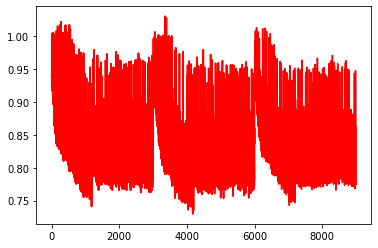

In [ ]:
#@title Do the Run!
#@markdown `n_batches` ignored with animation modes.
display_rate =  25 #@param{type: 'number'}
n_batches =  3 #@param{type: 'number'}

batch_size = 1 

def move_files(start_num, end_num, old_folder, new_folder):
    for i in range(start_num, end_num):
        old_file = old_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        new_file = new_folder + f'/{batch_name}({batchNum})_{i:04}.png'
        os.rename(old_file, new_file)

#@markdown ---


resume_run = False #@param{type: 'boolean'}
run_to_resume = 'latest' #@param{type: 'string'}
resume_from_frame = 'latest' #@param{type: 'string'}
retain_overwritten_frames = False #@param{type: 'boolean'}
if retain_overwritten_frames is True:
  retainFolder = f'{batchFolder}/retained'
  createPath(retainFolder)


skip_step_ratio = int(frames_skip_steps.rstrip("%")) / 100
calc_frames_skip_steps = math.floor(steps * skip_step_ratio)


if steps <= calc_frames_skip_steps:
  sys.exit("ERROR: You can't skip more steps than your total steps")

if resume_run:
  if run_to_resume == 'latest':
    try:
      batchNum
    except:
      batchNum = len(glob(f"{batchFolder}/{batch_name}(*)_settings.txt"))-1
  else:
    batchNum = int(run_to_resume)
  if resume_from_frame == 'latest':
    start_frame = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
  else:
    start_frame = int(resume_from_frame)+1
    if retain_overwritten_frames is True:
      existing_frames = len(glob(batchFolder+f"/{batch_name}({batchNum})_*.png"))
      frames_to_save = existing_frames - start_frame
      print(f'Moving {frames_to_save} frames to the Retained folder')
      move_files(start_frame, existing_frames, batchFolder, retainFolder)
else:
  start_frame = 0
  batchNum = len(glob(batchFolder+"/*.txt"))
  while path.isfile(f"{batchFolder}/{batch_name}({batchNum})_settings.txt") is True or path.isfile(f"{batchFolder}/{batch_name}-{batchNum}_settings.txt") is True:
    batchNum += 1

print(f'Starting Run: {batch_name}({batchNum}) at frame {start_frame}')

if set_seed == 'random_seed':
    random.seed()
    seed = random.randint(0, 2**32)
    # print(f'Using seed: {seed}')
else:
    seed = int(set_seed)

args = {
    'batchNum': batchNum,
    'prompts_series':split_prompts(text_prompts) if text_prompts else None,
    'image_prompts_series':split_prompts(image_prompts) if image_prompts else None,
    'seed': seed,
    'display_rate':display_rate,
    'n_batches':n_batches if animation_mode == 'None' else 1,
    'batch_size':batch_size,
    'batch_name': batch_name,
    'steps': steps,
    'width_height': width_height,
    'clip_guidance_scale': clip_guidance_scale,
    'tv_scale': tv_scale,
    'range_scale': range_scale,
    'sat_scale': sat_scale,
    'cutn_batches': cutn_batches,
    'init_image': init_image,
    'init_scale': init_scale,
    'skip_steps': skip_steps,
    'sharpen_preset': sharpen_preset,
    'keep_unsharp': keep_unsharp,
    'side_x': side_x,
    'side_y': side_y,
    'timestep_respacing': timestep_respacing,
    'diffusion_steps': diffusion_steps,
    'animation_mode': animation_mode,
    'video_init_path': video_init_path,
    'extract_nth_frame': extract_nth_frame,
    'key_frames': key_frames,
    'max_frames': max_frames if animation_mode != "None" else 1,
    'interp_spline': interp_spline,
    'start_frame': start_frame,
    'angle': angle,
    'zoom': zoom,
    'translation_x': translation_x,
    'translation_y': translation_y,
    'angle_series':angle_series,
    'zoom_series':zoom_series,
    'translation_x_series':translation_x_series,
    'translation_y_series':translation_y_series,
    'frames_scale': frames_scale,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'skip_step_ratio': skip_step_ratio,
    'calc_frames_skip_steps': calc_frames_skip_steps,
    'text_prompts': text_prompts,
    'image_prompts': image_prompts,
    'cut_overview': eval(cut_overview),
    'cut_innercut': eval(cut_innercut),
    'cut_ic_pow': cut_ic_pow,
    'cut_icgray_p': eval(cut_icgray_p),
    'intermediate_saves': intermediate_saves,
    'intermediates_in_subfolder': intermediates_in_subfolder,
    'steps_per_checkpoint': steps_per_checkpoint,
    'perlin_init': perlin_init,
    'perlin_mode': perlin_mode,
    'set_seed': set_seed,
    'eta': eta,
    'clamp_grad': clamp_grad,
    'clamp_max': clamp_max,
    'skip_augs': skip_augs,
    'randomize_class': randomize_class,
    'clip_denoised': clip_denoised,
    'fuzzy_prompt': fuzzy_prompt,
    'rand_mag': rand_mag,
}

args = SimpleNamespace(**args)

print('Prepping model...')
model, diffusion = create_model_and_diffusion(**model_config)
model.load_state_dict(torch.load(f'{model_path}/{diffusion_model}.pt', map_location='cpu'))
model.requires_grad_(False).eval().to(device)
for name, param in model.named_parameters():
    if 'qkv' in name or 'norm' in name or 'proj' in name:
        param.requires_grad_()
if model_config['use_fp16']:
    model.convert_to_fp16()

gc.collect()
torch.cuda.empty_cache()
try:
  do_run()
except KeyboardInterrupt:
    pass
finally:
    print('Seed used:', seed)
    gc.collect()
    torch.cuda.empty_cache()

# 5. Create the video

In [ ]:
# @title ### **Create video**
#@markdown Video file will save in the same folder as your images.

skip_video_for_run_all = True #@param {type: 'boolean'}

if skip_video_for_run_all == False:
  # import subprocess in case this cell is run without the above cells
  import subprocess
  from base64 import b64encode

  latest_run = batchNum

  folder = batch_name #@param
  run = latest_run #@param
  final_frame = 'final_frame'


  init_frame = 1#@param {type:"number"} This is the frame where the video will start
  last_frame = final_frame#@param {type:"number"} You can change i to the number of the last frame you want to generate. It will raise an error if that number of frames does not exist.
  fps = 12#@param {type:"number"}
  view_video_in_cell = False #@param {type: 'boolean'}

  frames = []
  # tqdm.write('Generating video...')

  if last_frame == 'final_frame':
    last_frame = len(glob(batchFolder+f"/{folder}({run})_*.png"))
    print(f'Total frames: {last_frame}')

  image_path = f"{outDirPath}/{folder}/{folder}({run})_%04d.png"
  filepath = f"{outDirPath}/{folder}/{folder}({run}).mp4"


  cmd = [
      'ffmpeg',
      '-y',
      '-vcodec',
      'png',
      '-r',
      str(fps),
      '-start_number',
      str(init_frame),
      '-i',
      image_path,
      '-frames:v',
      str(last_frame+1),
      '-c:v',
      'libx264',
      '-vf',
      f'fps={fps}',
      '-pix_fmt',
      'yuv420p',
      '-crf',
      '17',
      '-preset',
      'veryslow',
      filepath
  ]

  process = subprocess.Popen(cmd, cwd=f'{batchFolder}', stdout=subprocess.PIPE, stderr=subprocess.PIPE)
  stdout, stderr = process.communicate()
  if process.returncode != 0:
      print(stderr)
      raise RuntimeError(stderr)
  else:
      print("The video is ready")

  if view_video_in_cell:
      mp4 = open(filepath,'rb').read()
      data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
      display.HTML("""
      <video width=400 controls>
            <source src="%s" type="video/mp4">
      </video>
      """ % data_url)